In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tarfile
import scipy.io as sio
import numpy as np
import os
import cv2 as cv
import shutil
import random
from pathlib import Path
from console_progressbar import ProgressBar
import pandas as pd

In [2]:
pwd

'C:\\Users\\Morningstar\\Documents\\CARSv2'

In [3]:
path = Path('C:\\Users\\Morningstar\\Documents\\CARSv2');path

WindowsPath('C:/Users/Morningstar/Documents/CARSv2')

In [4]:
list(path.iterdir())

[WindowsPath('C:/Users/Morningstar/Documents/CARSv2/.ipynb_checkpoints'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBaseline.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasic.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-BasicResNet50.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2-TRES.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/CarsBasicv2.ipynb'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_meta.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_test_annos_withlabels.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/cars_train_annos.mat'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/data'),
 WindowsPath('C:/Users/Morningstar/Documents/CARSv2/merged'),
 WindowsPath('C:/Users/Morningstar/Documents/

In [4]:
cars_test = Path(path/'test')
cars_train = Path(path/'train')

In [5]:
len(list(cars_test.iterdir()))
len(list(cars_train.iterdir()))

8144

# **dataset modifikacije**
Ove modifikacije se rade samo jednom, kada se kreira merged folder sa svim testnim i trening podatcima radi lakseg pristupa.

Kada se kreira merged folder na google drive, od tada vise ne treba izvrsavati ovaj code cell za ostala testiranja.
Kod je potrebno prilagoditi ako se ne radi na google colab, odnosno izmjeniti imena foldera

In [9]:
#- promjena directory u google drive folder
#%cd /content/drive/My Drive/CARS 
#%mkdir merged -kreiranje merged directory-a
#%cp -a test/. merged -kopiranje svih slika iz test foldera u merged folder
#%cd merged -promjena dir u merged
#!rename 's/^/test_/' * - izmjena naziva svih slika u folderu da ispred imena imaju "test_"
#%cd .. -povratak u prvi dir
#%cp -a train/. merged -kopiranje svih slika iz test dir

# **Dataset pregled**
Prikaz i analiza file-ova koji pripadaju Stanford dataset-u

README.txt
This file gives documentation for the cars 196 dataset.
(http://ai.stanford.edu/~jkrause/cars/car_dataset.html)


**Metadata/Annotations**

Descriptions of the files are as follows:

-cars_meta.mat:
  Contains a cell array of class names, one for each class.

-cars_train_annos.mat:
  Contains the variable 'annotations', which is a struct array of length
  num_images and where each element has the fields:
    bbox_x1: Min x-value of the bounding box, in pixels
    bbox_x2: Max x-value of the bounding box, in pixels
    bbox_y1: Min y-value of the bounding box, in pixels
    bbox_y2: Max y-value of the bounding box, in pixels
    class: Integral id of the class the image belongs to.
    fname: Filename of the image within the folder of images.

-cars_test_annos.mat:
  Same format as 'cars_train_annos.mat', except the class is not provided.

In [5]:
from matplotlib.patches import Rectangle
from PIL import Image

In [7]:
#ucitavanje matlab fileova
cars_meta_p = sio.loadmat(path/'cars_meta.mat')
cars_train_annos_p = sio.loadmat(path/'cars_train_annos.mat')
cars_test_annos_p = sio.loadmat(path/'cars_test_annos.mat')

In [8]:
#ucitavanje label-a odnosno imena modela auta iz cars_meta matlab file-a u pandas dataframe
labels_p = [c for c in cars_meta_p['class_names'][0]]
labels_p = pd.DataFrame(labels_p, columns=['labels'])
labels_p.head()

labels
0  AM General Hummer SUV 2000
1         Acura RL Sedan 2012
2         Acura TL Sedan 2012
3        Acura TL Type-S 2008
4        Acura TSX Sedan 2012

In [9]:
#ucitavanje cars_train_annos matlab file-a u pandas dataframe da bi vidjeli kako podatci izgledaju
frame_p = [[i.flat[0] for i in line] for line in cars_train_annos_p['annotations'][0]]
columns_p = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class', 'fname']
df_train_p = pd.DataFrame(frame_p, columns=columns_p)
df_train_p['class'] = df_train_p['class']-1 # Python indeksiranje pocinje nulom.
df_train_p['fname'] = [cars_train/f for f in df_train_p['fname']] #  dodavanje full path-a do file-a
df_train_p.head()

bbox_x1  bbox_y1  bbox_x2  bbox_y2  class  \
0       39      116      569      375     13   
1       36      116      868      587      2   
2       85      109      601      381     90   
3      621      393     1484     1096    133   
4       14       36      133       99    105   

                                               fname  
0  C:\Users\Morningstar\Documents\CARSv2\train\00...  
1  C:\Users\Morningstar\Documents\CARSv2\train\00...  
2  C:\Users\Morningstar\Documents\CARSv2\train\00...  
3  C:\Users\Morningstar\Documents\CARSv2\train\00...  
4  C:\Users\Morningstar\Documents\CARSv2\train\00...

In [10]:
#spajanje labela sa df_train_p dataframe-om da bi imali bolji prikaz modela auta
df_train_p = df_train_p.merge(labels_p, left_on='class', right_index=True)
df_train_p = df_train_p.sort_index()
df_train_p.head()

bbox_x1  bbox_y1  bbox_x2  bbox_y2  class  \
0       39      116      569      375     13   
1       36      116      868      587      2   
2       85      109      601      381     90   
3      621      393     1484     1096    133   
4       14       36      133       99    105   

                                               fname  \
0  C:\Users\Morningstar\Documents\CARSv2\train\00...   
1  C:\Users\Morningstar\Documents\CARSv2\train\00...   
2  C:\Users\Morningstar\Documents\CARSv2\train\00...   
3  C:\Users\Morningstar\Documents\CARSv2\train\00...   
4  C:\Users\Morningstar\Documents\CARSv2\train\00...   

                                labels  
0                  Audi TTS Coupe 2012  
1                  Acura TL Sedan 2012  
2           Dodge Dakota Club Cab 2007  
3     Hyundai Sonata Hybrid Sedan 2012  
4  Ford F-450 Super Duty Crew Cab 2012

In [11]:
#isti postupak kao sa train matlab fileom samo za test podatke, test set ne sadrzi class_id jer model treba da to pogodi
frame_p = [[i.flat[0] for i in line] for line in cars_test_annos_p['annotations'][0]]
columns_p = ['bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'fname']
df_test_p = pd.DataFrame(frame_p, columns=columns_p)
df_test_p['fname'] = [cars_test/f for f in df_test_p['fname']]
df_test_p.head()

bbox_x1  bbox_y1  bbox_x2  bbox_y2  \
0       30       52      246      147   
1      100       19      576      203   
2       51      105      968      659   
3       67       84      581      407   
4      140      151      593      339   

                                               fname  
0  C:\Users\Morningstar\Documents\CARSv2\test\000...  
1  C:\Users\Morningstar\Documents\CARSv2\test\000...  
2  C:\Users\Morningstar\Documents\CARSv2\test\000...  
3  C:\Users\Morningstar\Documents\CARSv2\test\000...  
4  C:\Users\Morningstar\Documents\CARSv2\test\000...

In [12]:
#kod za prikaz slike
def get_assets(df, i):
    is_train = df is df_train_p
    folder = cars_train if is_train else cars_test
    image = Image.open(df['fname'][i])
    title = df['labels'][i] if is_train else 'Unclassified'

    xy = df['bbox_x1'][i], df['bbox_y1'][i]
    width = df['bbox_x2'][i] - df['bbox_x1'][i]
    height = df['bbox_y2'][i] - df['bbox_y1'][i]
    rect = Rectangle(xy, width, height, fill=False, color='r', linewidth=2)
    
    return (image, title, rect)

In [13]:
#kod za prikaz slike
def display_image(df, i):
    image, title, rect = get_assets(df, i)
    print(title)

    plt.imshow(image)
    plt.axis('off')
    plt.title(title)
    plt.gca().add_patch(rect)

Audi TTS Coupe 2012


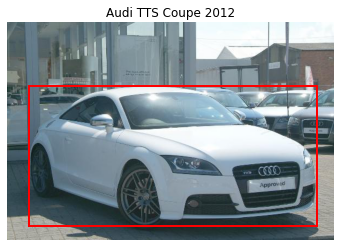

In [14]:
#primjer jedne slike iz trening seta
display_image(df_train_p, 0)

Unclassified


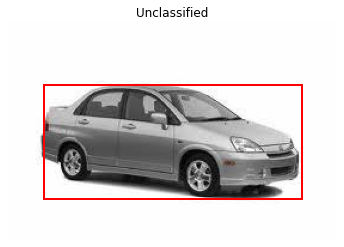

In [15]:
#primjer jedne slike iz test seta
display_image(df_test_p, 0)

In [16]:
#učestalost slika po modelu auta iz trening seta
freq_labels = df_train_p.groupby('labels').count()[['class']]
freq_labels = freq_labels.rename(columns={'class': 'count'})
freq_labels = freq_labels.sort_values(by='count', ascending=False)
freq_labels.head()

count
labels                                         
GMC Savana Van 2012                          68
Chrysler 300 SRT-8 2010                      49
Mercedes-Benz 300-Class Convertible 1993     48
Mitsubishi Lancer Sedan 2012                 48
Jaguar XK XKR 2012                           47

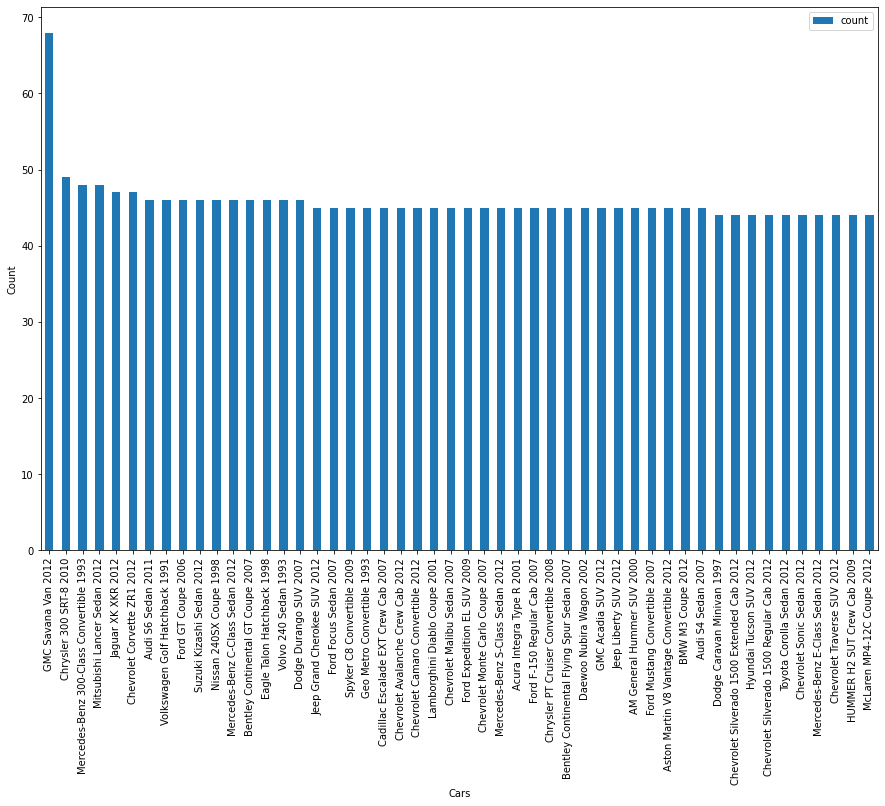

In [25]:
#top 50 modela po učestalosti iz trening seta
freq_labels.head(50).plot.bar(figsize=(15,10))
plt.xticks(rotation=90);
plt.xlabel("Cars");
plt.ylabel("Count");

# Dataset ucitavanje
Citav ovaj dio je preprocesiranje podataka da bi se ucitali svi potrebni podatci iz matlab file-ova. Ovaj proces je specifican za CARS dataset od Stanforda, odnosno nacin na koji su oni odlucili da formatiraju ovaj dataset gdje su svi bitni podatci kao class_id, class name, annotations svi u matlab filovima ekstenzije .mat .

In [26]:
# ucitavanje potrebnih matlab file-lova koji sadrzavaju podatke u labele tako sto iz matlab file-ova izvuce potrebni data,
#pohrani u varijable i kreira dictionary koji mapira class_id sa imenom klase da bi mogli ispisivati ime auta umjesto samo id-a
train_annos_path = 'cars_train_annos.mat'
test_annos_path = 'cars_test_annos_withlabels.mat'
classes_path = 'cars_meta.mat'

def get_labels(annos_path, classes_path):
    car_annos = sio.loadmat(path/annos_path)
    car_meta = sio.loadmat(path/classes_path)
    annotations = car_annos["annotations"][0,:]
    nclasses = len(car_meta["class_names"][0])
    class_names = dict(zip(range(1,nclasses),[c[0] for c in car_meta["class_names"][0]]))
    
    labelled_images = {}
    dataset = []
    for i,arr in enumerate(annotations):
        # zadnji podatak u redu je ime slike
        # ostatak su podatci, prvi bbox, class id 
        dataset.append([y[0][0] for y in arr][0:5]+[arr[5][0]])
    # Konverzija u pandas DataFrame, i dodavanje imena klasa
    temp_df = pd.DataFrame(dataset, 
                      columns =['BBOX_X1','BBOX_Y1','BBOX_X2','BBOX_Y2','ClassID','filename'])

    temp_df = temp_df.assign(ClassName=temp_df.ClassID.map(dict(class_names)))
    temp_df.columns = ['bbox_x1','bbox_y1','bbox_x2','bbox_y2','class_id','filename', 'class_name']
    return temp_df

In [27]:
#kreiranje dataframe-a za trening podatke te csv-a sa svim potrebnim podatcima
train_df = get_labels(train_annos_path, classes_path)
train_df['is_test'] = 0
#train_df.to_csv(path/'train_labels.csv', index=False)

test_df = get_labels(test_annos_path, classes_path)
test_df['is_test'] = 1

# Add missing class name! - 'smart fortwo Convertible 2012'
train_df.loc[train_df['class_name'].isnull(), 'class_name'] = 'smart fortwo Convertible 2012'
test_df.loc[test_df['class_name'].isnull(), 'class_name'] = 'smart fortwo Convertible 2012'
#kreiranje labels_df DataFrame-a koji sadrzi sve podatke i o testnim i trening slikama
frames = [train_df, test_df]
labels_df = pd.concat(frames)
labels_df.reset_index(inplace=True, drop=True)
labels_df = labels_df[['filename', 'bbox_x1', 'bbox_y1','bbox_x2','bbox_y2',
                            'class_id', 'class_name','is_test']]

# prilagodavanje imena testnih fajlova (posto koristimo merged folder gdje su i testni i trening podatci)
labels_df['filename'].loc[labels_df['is_test']==1] = 'test_' + labels_df['filename']

# Add the cropped file names
labels_df['filename_cropped'] = labels_df['filename'].copy()
labels_df['filename_cropped'].loc[labels_df['is_test']==0] = 'cropped_' + labels_df['filename']

labels_df.head()

c:\users\morningstar\anaconda3\envs\carsv2\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0  00001.jpg       39      116      569      375        14   
1  00002.jpg       36      116      868      587         3   
2  00003.jpg       85      109      601      381        91   
3  00004.jpg      621      393     1484     1096       134   
4  00005.jpg       14       36      133       99       106   

                            class_name  is_test   filename_cropped  
0                  Audi TTS Coupe 2012        0  cropped_00001.jpg  
1                  Acura TL Sedan 2012        0  cropped_00002.jpg  
2           Dodge Dakota Club Cab 2007        0  cropped_00003.jpg  
3     Hyundai Sonata Hybrid Sedan 2012        0  cropped_00004.jpg  
4  Ford F-450 Super Duty Crew Cab 2012        0  cropped_00005.jpg

In [28]:
#broj imena klasa i class_id-ova
labels_df['class_name'].nunique(), labels_df['class_id'].nunique() 

(196, 196)

In [29]:
#dodavanje height i width property-a za bbox da bi se mogli koristiti sa fast.ai formatom koji je hw_bb
labels_df['bbox_h'] = (labels_df['bbox_y2'] - labels_df['bbox_y1']) + 1
labels_df['bbox_w'] = (labels_df['bbox_x2'] - labels_df['bbox_x1']) + 1
labels_df.head()

filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0  00001.jpg       39      116      569      375        14   
1  00002.jpg       36      116      868      587         3   
2  00003.jpg       85      109      601      381        91   
3  00004.jpg      621      393     1484     1096       134   
4  00005.jpg       14       36      133       99       106   

                            class_name  is_test   filename_cropped  bbox_h  \
0                  Audi TTS Coupe 2012        0  cropped_00001.jpg     260   
1                  Acura TL Sedan 2012        0  cropped_00002.jpg     472   
2           Dodge Dakota Club Cab 2007        0  cropped_00003.jpg     273   
3     Hyundai Sonata Hybrid Sedan 2012        0  cropped_00004.jpg     704   
4  Ford F-450 Super Duty Crew Cab 2012        0  cropped_00005.jpg      64   

   bbox_w  
0     531  
1     833  
2     517  
3     864  
4     120

Audi TTS Coupe 2012


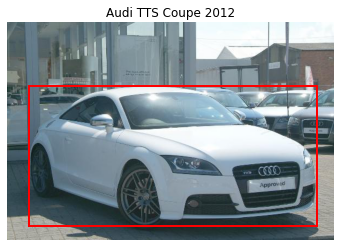

In [30]:
display_image(df_train_p, 0)

In [6]:
#funkcije za ucitavanje slike
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

# White text on black outline
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])
    
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], b[3], b[2], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)
    
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

In [7]:
# funkcija za rezanje slike na osnovu anotacije tj cetverougla oko auta
def crop(df, path, i):
    image = plt.imread(path/df['filename'][i])
    x1 = df['bbox_x1'][i]
    y1 = df['bbox_y1'][i]
    h = df['bbox_h'][i]
    w = df['bbox_w'][i]
    
    if len(image.shape) == 3:
        return image[y1:y1+h , x1:x1+w, :]
    else:
        # ako je slika grayscale, tj ima dva channela
        return image[y1:y1+h , x1:x1+w]

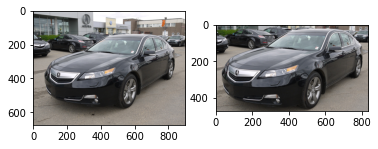

In [11]:
#kako izgleda izrezana trening slika
fig = plt.figure()
ax = fig.add_subplot(121)
p = path/'train/'
ax.imshow(plt.imread(p/labels_df['filename'][1]))

ax1 = fig.add_subplot(122)
ax1.imshow(crop(labels_df,p, 1))

plt.show()

# Ucitavanje i kreiranje DataBlock i DataLoaders objekta

In [8]:
from fastai.vision.all import *
from fastai.metrics import error_rate
from fastai import *
import cv2 as cv
import numpy as np
import pandas as pd
import scipy.io as sio
from PIL import Image
import timm
from wwf.vision.timm import *
import torch
import torchvision
import random
from torch.distributions.beta import Beta

In [9]:
def random_seed(seed_value, use_cuda):
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    random.seed(seed_value) # Python
    if use_cuda: 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [12]:
labels_df.head(20)

filename  bbox_x1  bbox_y1  bbox_x2  bbox_y2  class_id  \
0   00001.jpg       39      116      569      375        14   
1   00002.jpg       36      116      868      587         3   
2   00003.jpg       85      109      601      381        91   
3   00004.jpg      621      393     1484     1096       134   
4   00005.jpg       14       36      133       99       106   
5   00006.jpg      259      289      515      416       123   
6   00007.jpg       88       80      541      397        89   
7   00008.jpg       73       79      591      410        96   
8   00009.jpg       20      126     1269      771       167   
9   00010.jpg       21      110      623      367        58   
10  00011.jpg       51       93      601      393        49   
11  00012.jpg        6       62      499      286       186   
12  00013.jpg       30       36      418      307       135   
13  00014.jpg       31      246      778      540        85   
14  00015.jpg       32       77      589      379       193   
15  00016.jpg       27       49      611      396       172   
16  00017.jpg       39       52      233      150        14   
17  00018.jpg        3        8      190      147        73   
18  00019.jpg      247      287     1366      761       192   
19  00020.jpg       17      281      961      596        57   

                                         class_name  is_test  \
0                               Audi TTS Coupe 2012        0   
1                               Acura TL Sedan 2012        0   
2                        Dodge Dakota Club Cab 2007        0   
3                  Hyundai Sonata Hybrid Sedan 2012        0   
4               Ford F-450 Super Duty Crew Cab 2012        0   
5                        Geo Metro Convertible 1993        0   
6                            Dodge Journey SUV 2012        0   
7                          Dodge Charger Sedan 2012        0   
8                      Mitsubishi Lancer Sedan 2012        0   
9                       Chevrolet Traverse SUV 2012        0   
10                          Buick Verano Sedan 2012        0   
11                          Toyota Sequoia SUV 2012        0   
12                       Hyundai Elantra Sedan 2007        0   
13                       Dodge Caravan Minivan 1997        0   
14                         Volvo C30 Hatchback 2012        0   
15                         Plymouth Neon Coupe 1999        0   
16                              Audi TTS Coupe 2012        0   
17                      Chevrolet Malibu Sedan 2007        0   
18                 Volkswagen Beetle Hatchback 2012        0   
19  Chevrolet Corvette Ron Fellows Edition Z06 2007        0   

     filename_cropped  bbox_h  bbox_w  
0   cropped_00001.jpg     260     531  
1   cropped_00002.jpg     472     833  
2   cropped_00003.jpg     273     517  
3   cropped_00004.jpg     704     864  
4   cropped_00005.jpg      64     120  
5   cropped_00006.jpg     128     257  
6   cropped_00007.jpg     318     454  
7   cropped_00008.jpg     332     519  
8   cropped_00009.jpg     646    1250  
9   cropped_00010.jpg     258     603  
10  cropped_00011.jpg     301     551  
11  cropped_00012.jpg     225     494  
12  cropped_00013.jpg     272     389  
13  cropped_00014.jpg     295     748  
14  cropped_00015.jpg     303     558  
15  cropped_00016.jpg     348     585  
16  cropped_00017.jpg      99     195  
17  cropped_00018.jpg     140     188  
18  cropped_00019.jpg     475    1120  
19  cropped_00020.jpg     316     945

In [37]:
#dataframe sa samo trening podatcima
train_labels_df = labels_df.loc[labels_df['is_test']==0, ['filename', 'class_name', 'class_id']].copy()
train_labels_df.head(20)

filename                                       class_name  class_id
0   00001.jpg                              Audi TTS Coupe 2012        14
1   00002.jpg                              Acura TL Sedan 2012         3
2   00003.jpg                       Dodge Dakota Club Cab 2007        91
3   00004.jpg                 Hyundai Sonata Hybrid Sedan 2012       134
4   00005.jpg              Ford F-450 Super Duty Crew Cab 2012       106
5   00006.jpg                       Geo Metro Convertible 1993       123
6   00007.jpg                           Dodge Journey SUV 2012        89
7   00008.jpg                         Dodge Charger Sedan 2012        96
8   00009.jpg                     Mitsubishi Lancer Sedan 2012       167
9   00010.jpg                      Chevrolet Traverse SUV 2012        58
10  00011.jpg                          Buick Verano Sedan 2012        49
11  00012.jpg                          Toyota Sequoia SUV 2012       186
12  00013.jpg                       Hyundai Elantra Sedan 2007       135
13  00014.jpg                       Dodge Caravan Minivan 1997        85
14  00015.jpg                         Volvo C30 Hatchback 2012       193
15  00016.jpg                         Plymouth Neon Coupe 1999       172
16  00017.jpg                              Audi TTS Coupe 2012        14
17  00018.jpg                      Chevrolet Malibu Sedan 2007        73
18  00019.jpg                 Volkswagen Beetle Hatchback 2012       192
19  00020.jpg  Chevrolet Corvette Ron Fellows Edition Z06 2007        57

Spasavanje labels_df i train_labels_df unutar csv da ne bi ponavljali ovaj dio koda u ostalim varijantama.

In [92]:
labels_df.to_csv(path/'labels_with_annos.csv', index=False)
train_labels_df.to_csv(path/'train_labels_with_annos.csv', index= False)

In [11]:
labels_df = pd.read_csv(path/'labels_with_annos.csv')
train_labels_df = pd.read_csv(path/'train_labels_with_annos.csv')

Koristenje DataBlock API iz fastai da ucitamo trening set podataka

In [42]:
dblock = DataBlock()

In [43]:
dsets = dblock.datasets(train_labels_df)

Bitno je primjetit da po default-u datablock uradi nasumicnu podjelu trening seta na trening i validacijski set.
Ako ne specificiramo koliko on automatski ostavi 20% podataka za validacijski set.

In [50]:
len(dsets.train), len(dsets.valid)

(6516, 1628)

Posto nismo specificirali sta je ovisna a sta neovisna varijabla, odnosno sta je slika a sta labela, DataBlock API automatski uzima citav ulaz iz proslijedjenog fajla.

Posto smo proslijedili Pandas DataFrame to znaci da ce uzeti citav prvi red sa imenima kolona kao sto mozemo vidjeti ispod.

In [46]:
x,y = dsets.train[0]
x,y

(filename                 02279.jpg
 class_name    Volvo 240 Sedan 1993
 class_id                       194
 Name: 2278, dtype: object,
 filename                 02279.jpg
 class_name    Volvo 240 Sedan 1993
 class_id                       194
 Name: 2278, dtype: object)

Sta nama zapravo treba je ime fajla koji sadrzava sliku i ime klase koja predstavlja marku auta.

Te informacije dobijamo tako sto ih zatrazimo iz Pandas DataFrame-a kao sto je specificirano ispod.

In [47]:
x['filename'], y['class_name']

('02279.jpg', 'Volvo 240 Sedan 1993')

Međutim da bi DataBlock ucitao sve slike, nama treba puni put do lokacije tih slika.
Zbog toga kreiramo funkciju get_x koja ce otici na path u folder train i dobaviti filename iz DataFrame-a kojeg mu proslijedimo.

Isto tako da bi dobili za svaku sliku njenu klasu, iz istog DataFrame-a kroz funkciju get_y dobavljamo samo 'class_name' polje.

In [13]:
def get_x(df): return path/'merged'/df['filename']
def get_y(df): return df['class_name']
#dblock = DataBlock(get_x=get_x, get_y=get_y)
#dsets = dblock.datasets(train_labels_df)
#dsets.train[0]

Sada kada znamo kako doci do ovisne i neovisne varijable, trebamo specificirati koji tip one prestavljaju DataBlock API-u.

To se radi tako sto navedemo unutar definicije koje tipove blokova koristimo, u nasem slucaju to je ImageBlock jer koristimo slike i CategoryBlock jer je u pitanju klasifikacija gdje je rezultat jedna kategorija.

Kada to specificiramo DataBlock API pretvori nase podatke u potrebni format za stvaranje i treniranje modela.

In [49]:
dblock = DataBlock((ImageBlock, CategoryBlock),
                   get_x=get_x, get_y= get_y)
dsets = dblock.datasets(train_labels_df)
dsets.train[0]

(PILImage mode=RGB size=1600x900, TensorCategory(4, dtype=torch.int32))

Da bi dovrsili stvaranje DataBlock-a, jos moramo osigurati da su sve slike iste velicine tako sto cemo postaviti transformaciju podataka item_tfms na Resize(460) sto znaci da ce sve slike biti velicine 460x460.

Zatim trebamo odrediti na koji nacin ce DataBlock API podijeliti slike na trening i validacijski set, sto cemo rijesiti tako sto postavimo splitter na RandomSplitter.

Nakon toga jos mozemo specificirati kakve ce transformacije biti aplicirane na batch-ove podataka tokom treninga za sta cemo koristiti defaultni aug_transforms i postaviti velicinu na 224.

Na kraju sve te podatke preko DataLoader-a ucitamo i postavimo velicinu jednog batch-a, tada su podatci spremi za trening.

In [16]:
random_seed(42,True)

dblock = DataBlock((ImageBlock, CategoryBlock),
                  splitter=RandomSplitter(seed=42),
                  get_x=get_x, 
                  get_y=get_y,
                  item_tfms=Resize(460, method='squish'),
                  batch_tfms=aug_transforms(size=224, min_scale=0.75))
dls = dblock.dataloaders(train_labels_df, bs=64, num_workers=0)

Sada mozemo vidjeti kako izgledaju podatci u nasem DataLoader-u tako sto ucitamo jedan batch.

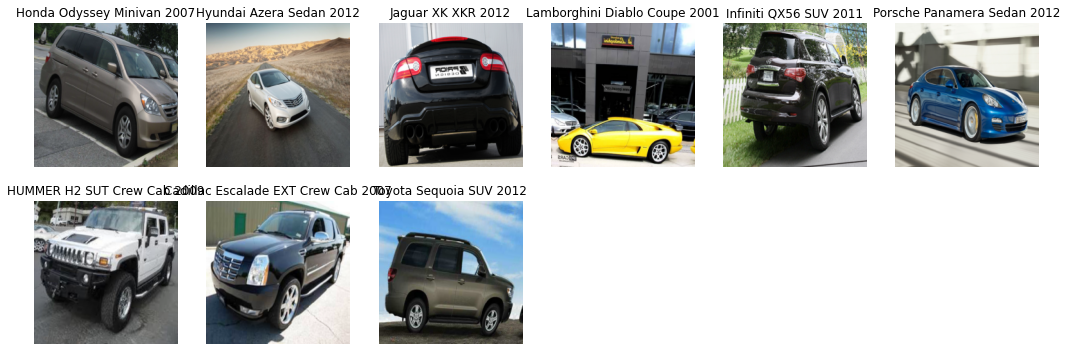

In [17]:
dls.show_batch(nrows=2, ncols=6)

In [27]:
#broj klasa
dls.c

196

## Kreiranje baseline ResNet50 modela

Kreiramo model koristeci ResNet50 arhitekturu sa defaultnim hiperparametrima.
To podrazumijeva loss funkciju Cross Entropy Loss sa softmax aktivacijom.
Kao optimizator se koristi Adam i ne koriste se nikakvi dodatni CallBacks za regularizaciju treninga.
Kao metrika po kojoj cemo pratiti trening koristimo procenat gresaka (1-accuracy).

Dio to_fp16() definira mixed precision trening koji ubrzava trening na određenim grafickim karticama kao sto je moja RTX 2060 Super.

In [19]:
learn = cnn_learner(dls, resnet50, metrics=accuracy).to_fp16()

Nakon kreiranja modela mozemo krenuti sa treningom.

## Treniranje modela

Za treniranje modela koristit cemo ugrađenu fast.ai fine_tune funkciju koja koristi dosta od najmodernijih metoda treniranja unutar jednog poziva.

Metode koje koristi su transfer learning, freeze i unfreeze slojeva i diskriminativna rata učenja.

In [73]:
Learner.fine_tune??

In [20]:
learn.fine_tune(20, freeze_epochs=4)

In [92]:
learn.save('baseline-resnet50')

Path('models/baseline-resnet50.pth')

In [177]:
learn.load('baseline-resnet50')

## Funkcije za bolji prikaz top gubitaka i konfuzije

In [147]:
def compare_top_losses(k, interp, labels_df, num_imgs):
    tl_val,tl_idx = interp.top_losses(k)
    classes = interp.vocab
    probs = interp.preds
    columns = 2
    rows = 2
    
    topl_idx = 0   
    for i,idx in enumerate(tl_idx):
        fig=plt.figure(figsize=(10, 8))
        columns = 2
        rows = 1
        
        # Actual Image
        act_im,cl = interp.dl.dataset[int(idx)]
        cl = int(cl)        
        act_cl = classes[cl]
        act_fn = labels_df.loc[labels_df['class_name'] == act_cl]['filename'].values[0]
        
        # Predicted Image
        pred_cl = int(np.argmax(interp.preds[int(idx)]))
        pred_cl = classes[pred_cl]
        pred_fn = labels_df.loc[labels_df['class_name'] == pred_cl]['filename'].values[0]
        
        print(f'PREDICTION:{pred_cl}, ACTUAL:{act_cl}')
        print(f'Loss: {tl_val[i]:.2f}, Probability: {probs[i][cl]:.4f}')
              
        # Add image to the left column
        img_path = 'train/' + pred_fn
        im = plt.imread(path/img_path)
        fig.add_subplot(rows, columns, 1)
        plt.imshow(im)
        
        # Add image to the right column, need to change the tensor shape (permute) for matplotlib
        fig.add_subplot(rows, columns, 2)
        plt.imshow(act_im)

        plt.show()

In [17]:
def compare_most_confused(most_confused, labels_df, num_imgs, rank):
    c1 = most_confused[:][rank][0]
    c2 = most_confused[:][rank][1]
    n_confused = most_confused[:3][0][1]
    print(most_confused[:][rank])
      
    # set the list of 
    f_1 = labels_df.loc[labels_df['class_name'] == c1]['filename'].values
    f_2 = labels_df.loc[labels_df['class_name'] == c2]['filename'].values

    fig=plt.figure(figsize=(10, 8))
    columns = 2
    rows = num_imgs
    for i in range(1, columns*rows +1, 2):
        # Add image to the left column
        img_path = 'train/' + f_1[i]
        im = plt.imread(path/img_path)
        fig.add_subplot(rows, columns, i)
        plt.imshow(im)
        
        # Add image to the right column
        img_path = 'train/' + f_2[i]
        im = plt.imread(path/img_path)
        fig.add_subplot(rows, columns, i+1)
        plt.imshow(im)

    plt.show()

# Rezulatati

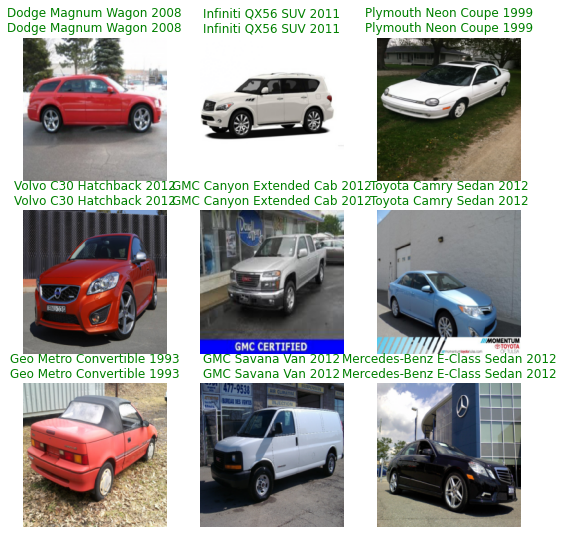

In [21]:
learn.show_results()

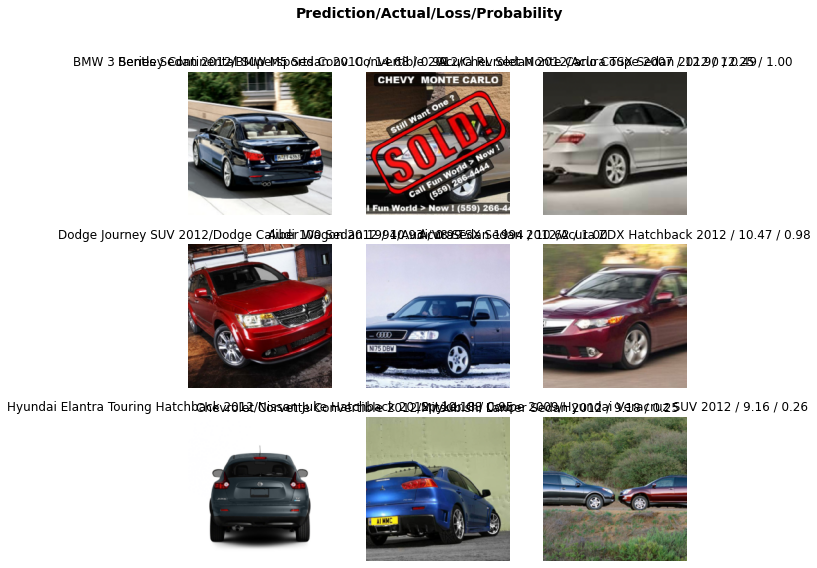

In [18]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(9,9))

In [19]:
most_confused = interp.most_confused()

In [ ]:
for i in range(0,8):
    compare_most_confused(most_confused=most_confused, labels_df=labels_df, 
                          num_imgs=3, rank=i)

PREDICTION:BMW 3 Series Sedan 2012, ACTUAL:BMW M5 Sedan 2010
Loss: 14.68, Probability: 0.0000


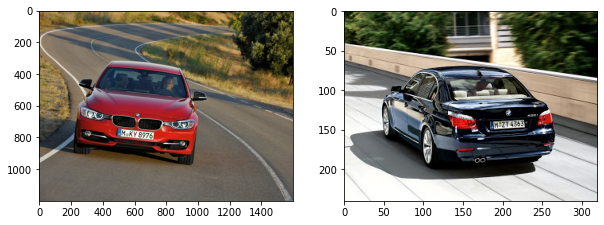

PREDICTION:Bentley Continental Supersports Conv. Convertible 2012, ACTUAL:Chevrolet Monte Carlo Coupe 2007
Loss: 12.90, Probability: 0.0000


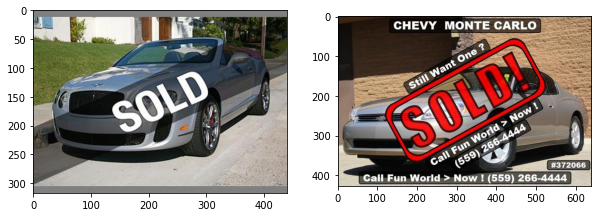

PREDICTION:Acura RL Sedan 2012, ACTUAL:Acura TSX Sedan 2012
Loss: 12.25, Probability: 0.0005


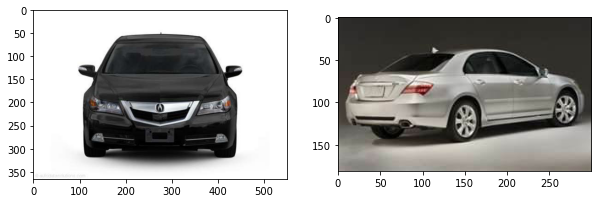

PREDICTION:Dodge Journey SUV 2012, ACTUAL:Dodge Caliber Wagon 2012
Loss: 10.93, Probability: 0.0000


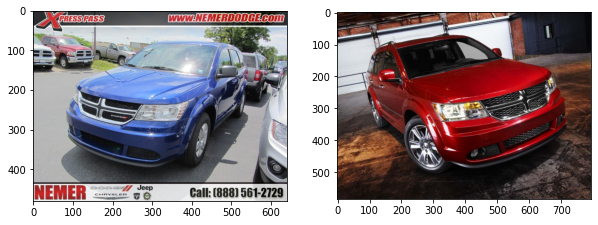

PREDICTION:Audi 100 Sedan 1994, ACTUAL:Audi V8 Sedan 1994
Loss: 10.62, Probability: 0.0000


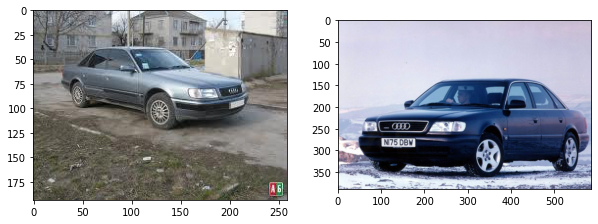

PREDICTION:Acura TSX Sedan 2012, ACTUAL:Acura ZDX Hatchback 2012
Loss: 10.47, Probability: 0.0000


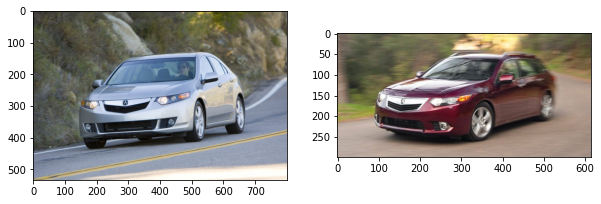

PREDICTION:Hyundai Elantra Touring Hatchback 2012, ACTUAL:Nissan Juke Hatchback 2012
Loss: 10.18, Probability: 0.0000


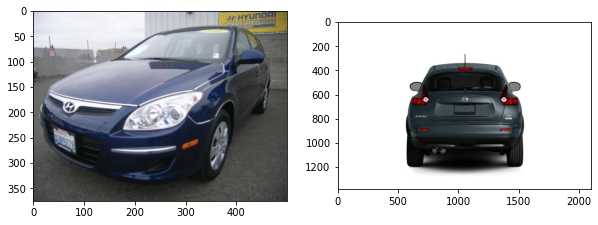

PREDICTION:Chevrolet Corvette Convertible 2012, ACTUAL:Mitsubishi Lancer Sedan 2012
Loss: 9.18, Probability: 0.0000


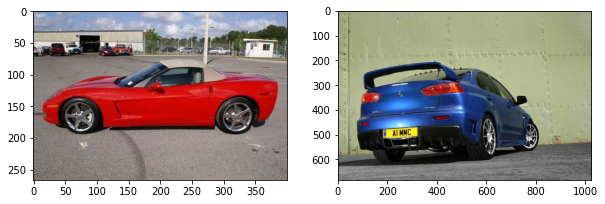

PREDICTION:Spyker C8 Coupe 2009, ACTUAL:Hyundai Veracruz SUV 2012
Loss: 9.16, Probability: 0.0000


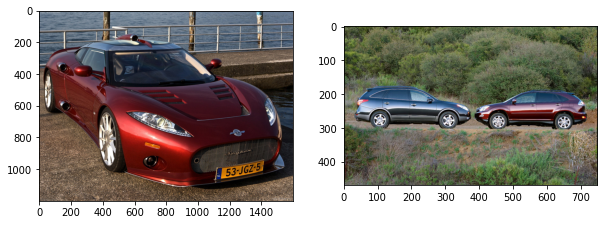

PREDICTION:Suzuki SX4 Hatchback 2012, ACTUAL:Suzuki SX4 Sedan 2012
Loss: 9.11, Probability: 0.0000


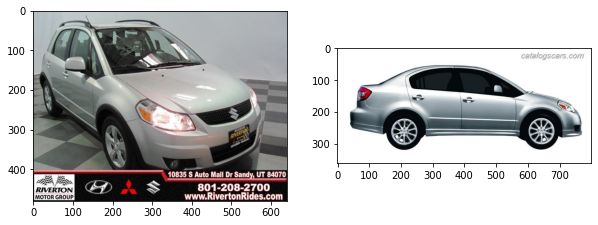

In [148]:
compare_top_losses(10, interp, labels_df, 1)

# Testiranje na testnom setu podataka

Kreiranje pandas DataFrame objekta koji sadrzava samo testne slike

In [22]:
test_labels_df = labels_df.loc[labels_df['is_test']==1, ['filename', 'class_name', 'class_id']].copy()
test_labels_df

filename                           class_name  class_id
8144   test_00001.jpg              Suzuki Aerio Sedan 2007       181
8145   test_00002.jpg  Ferrari 458 Italia Convertible 2012       103
8146   test_00003.jpg                Jeep Patriot SUV 2012       145
8147   test_00004.jpg              Toyota Camry Sedan 2012       187
8148   test_00005.jpg             Tesla Model S Sedan 2012       185
...               ...                                  ...       ...
16180  test_08037.jpg           Chevrolet Sonic Sedan 2012        63
16181  test_08038.jpg                   Audi V8 Sedan 1994        16
16182  test_08039.jpg                  Audi 100 Sedan 1994        17
16183  test_08040.jpg              BMW Z4 Convertible 2012        38
16184  test_08041.jpg                      BMW X5 SUV 2007        32

[8041 rows x 3 columns]

Dodavanje id-ova iz vokabulara naseg modela u DataFrame radi poređenja tacnosti predikcija

In [75]:
def convert_to_vocab(x):
    return vocab_df.index[vocab_df['class_name']==x][0]

In [76]:
test_labels_df['vocab_id'] = test_labels_df['class_name'].apply(convert_to_vocab)
test_labels_df.head()

filename                           class_name  class_id  vocab_id
8144  test_00001.jpg              Suzuki Aerio Sedan 2007       181       180
8145  test_00002.jpg  Ferrari 458 Italia Convertible 2012       103       100
8146  test_00003.jpg                Jeep Patriot SUV 2012       145       147
8147  test_00004.jpg              Toyota Camry Sedan 2012       187       186
8148  test_00005.jpg             Tesla Model S Sedan 2012       185       184

Spasavanje test_labels_df u csv da ne bi morali ponavljati ovaj kod u slijedecim eksperimentima

In [93]:
test_labels_df.to_csv(path/'test_labels_with_annos.csv', index= False)

In [94]:
test_labels_df = pd.read_csv(path/'test_labels_with_annos.csv'); test_labels_df.head()

filename                           class_name  class_id  vocab_id
0  test_00001.jpg              Suzuki Aerio Sedan 2007       181       180
1  test_00002.jpg  Ferrari 458 Italia Convertible 2012       103       100
2  test_00003.jpg                Jeep Patriot SUV 2012       145       147
3  test_00004.jpg              Toyota Camry Sedan 2012       187       186
4  test_00005.jpg             Tesla Model S Sedan 2012       185       184

Predikcija na samo jednoj slici iz testnog seta

In [23]:
test_item = path/'merged'/test_labels_df['filename'][8145]; test_item

Path('C:/Users/Morningstar/Documents/CARSv2/merged/test_00002.jpg')

In [24]:
pred_y,pred_idx,probs=learn.predict(test_item)

In [78]:
act_y_id = test_labels_df['vocab_id'][8145]
act_y = test_labels_df['class_name'][8145]

In [79]:
pred_y,act_y

('Ferrari 458 Italia Convertible 2012', 'Ferrari 458 Italia Convertible 2012')

In [80]:
pred_idx,act_y_id

(tensor(100), 100)

Ucitavanje testnih itema na isti nacin kao sto smo ucitavali trening iteme kroz get_x funkciju

In [81]:
test_items = get_x(test_labels_df);test_items

8144     C:\Users\Morningstar\Documents\CARSv2\merged\test_00001.jpg
8145     C:\Users\Morningstar\Documents\CARSv2\merged\test_00002.jpg
8146     C:\Users\Morningstar\Documents\CARSv2\merged\test_00003.jpg
8147     C:\Users\Morningstar\Documents\CARSv2\merged\test_00004.jpg
8148     C:\Users\Morningstar\Documents\CARSv2\merged\test_00005.jpg
                                    ...                             
16180    C:\Users\Morningstar\Documents\CARSv2\merged\test_08037.jpg
16181    C:\Users\Morningstar\Documents\CARSv2\merged\test_08038.jpg
16182    C:\Users\Morningstar\Documents\CARSv2\merged\test_08039.jpg
16183    C:\Users\Morningstar\Documents\CARSv2\merged\test_08040.jpg
16184    C:\Users\Morningstar\Documents\CARSv2\merged\test_08041.jpg
Name: filename, Length: 8041, dtype: object

Kreiranje test dataloader objekta koji ce sadrzavati sve test iteme

In [82]:
test_dl = learn.dls.test_dl(test_items)

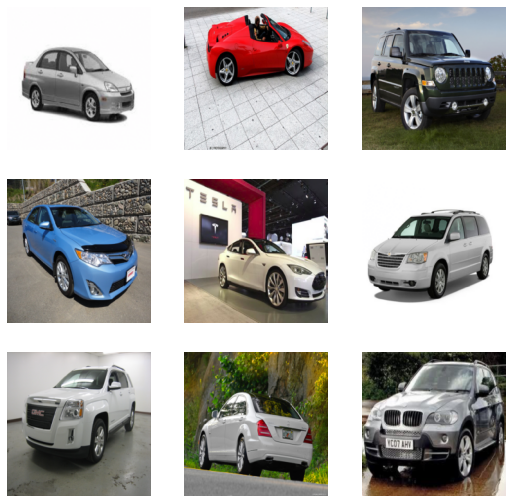

In [83]:
test_dl.show_batch()

Predikcije nad citavim test setom

In [84]:
preds = learn.get_preds(dl=test_dl)

Prikaz predikcije za prvu sliku, preds[0][0] vraca sansu za svaku klasu, odnosno tensor koji sadrzi 196 vrijednosti

In [86]:
preds[0][0]

tensor([7.8569e-08, 1.3108e-06, 2.8306e-04, 7.0725e-06, 2.8468e-05, 2.2697e-05,
        1.1145e-07, 2.6007e-09, 1.2025e-08, 6.4619e-09, 3.5686e-09, 5.5305e-05,
        1.0151e-05, 3.4875e-06, 3.8136e-09, 5.3154e-09, 8.9305e-07, 5.5451e-07,
        8.6798e-08, 6.3917e-07, 2.3598e-06, 8.6544e-08, 4.6930e-06, 4.7191e-08,
        2.7054e-07, 5.6868e-08, 3.6620e-06, 5.1283e-07, 4.4752e-07, 8.9917e-07,
        1.9487e-06, 3.5847e-05, 5.5559e-07, 4.9739e-09, 5.1678e-08, 2.2161e-08,
        1.3250e-06, 5.2741e-09, 8.7993e-08, 2.9082e-06, 3.0051e-09, 4.6188e-08,
        8.4102e-10, 5.3041e-07, 1.6791e-09, 1.9478e-09, 1.7565e-08, 7.9108e-08,
        5.8903e-08, 4.3280e-07, 2.6329e-05, 1.1693e-06, 7.1002e-06, 5.2362e-05,
        1.1311e-06, 3.3283e-05, 2.6011e-08, 2.6466e-07, 3.8541e-07, 1.1256e-06,
        7.1758e-07, 9.1141e-08, 1.9078e-04, 1.9916e-04, 2.3054e-05, 1.1435e-05,
        3.0597e-06, 1.4767e-06, 3.1883e-05, 2.1933e-07, 9.9156e-06, 3.9525e-05,
        6.6961e-06, 2.8464e-06, 4.5664e-

Da bi dobili lokaciju one vrijednosti za koju model misli da je tacna moramo koristit argmax funkciju koja vraca lokaciju najvece vrijednosti u nizu

In [87]:
np.argmax(preds[0][0])

tensor(180)

In [88]:
learn.dls.vocab[180]

'Suzuki Aerio Sedan 2007'

Da bi provjerili tacnost na citavom datasetu prvo trebamo spasiti sve predikcije u jednu varijablu.

Mozemo primjetiti oblik tensora za predikcije, koji je broj slika (8041) sa broj klasa (196), jer za svaku sliku sadrzava 196 vrijednosti koje izgledaju isto kao sto smo vidjeli iznad.

In [89]:
a = preds[0]; a.shape

torch.Size([8041, 196])

Zatim nam treba varijabla, tj tensor s kojim cemo porediti ove predikcije, odnosno onaj koji sadrzava stvarne vrijednosti klasa za slike iz test seta.

Za te potrebe kreirat cemo numpy array koji cemo poslije pretvoriti u PyTorch tensor.

In [90]:
b = np.array(test_labels_df['vocab_id'],dtype=np.int)
b = torch.from_numpy(b);b.shape

torch.Size([8041])

Sve sto nam preostaje je da pozovemo accuracy funkciju koja ce za nas na proslijedenom tensoru a uraditi argmax funkciju i porediti sa proslijedenim tensorom b

In [91]:
accuracy(a,b)

tensor(0.8195)

Tacnost ovog baseline modela na testnom setu podataka je 81.95%